# Face Aging

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from datetime import datetime
from keras.preprocessing import image
from keras.utils import to_categorical

from PIL import Image

from src.face_aging import CGAN_FaceAging

2023-04-25 17:55:54.640764: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 17:55:55.486565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dataset

### Download Data

If you use the Notebook in a new environment, without you ever had downloaded the data please execute the following steps.

In [2]:
def get_age_category(age):
    if 0 < age <= 18:
        return 0
    elif 18 < age <= 29:
        return 1
    elif 29 < age <= 39:
        return 2
    elif 39 < age <= 49:
        return 3
    elif 49 < age <= 59:
        return 4
    elif age >= 60:
        return 5

In [3]:
def ages_to_category(ages):
        return [get_age_category(age) for age in ages]

In [4]:
def calculate_age(taken, dob):
  birth = datetime.fromordinal(max(int(dob) - 366, 1))
  
  if birth.month < 7:
    return taken - birth.year
  else:
    return taken - birth.year - 1

In [5]:
def load_data(wiki_dir, dataset = 'wiki'):
    ## Load the wiki.mat file
    meta = loadmat(os.path.join(wiki_dir, "{}.mat".format(dataset)))

    ## Load the list of all files
    full_path = meta[dataset][0, 0]["full_path"][0]

    ## List of Matlab serial date numbers
    dob = meta[dataset][0, 0]["dob"][0]

    ## List of years when photo was taken
    photo_taken = meta[dataset][0, 0]["photo_taken"][0]  # year

    ## Calculate age for all dobs
    age = [calculate_age(photo_taken[i], dob[i]) for i in range(len(dob))]

    ## Create a list of tuples containing a pair of an image path and age
    images = []
    age_list = []
    
    for index, image_path in enumerate(full_path):
        if age[index] > 0 and age[index] <= 100:
            images.append(image_path[0])
            age_list.append(age[index])

    ## Return a list of all images and respective age
    return images, age_list

In [6]:
def load_images(data_dir, image_paths, image_shape, n_images):
    images = []
  
    for i, image_path in enumerate(image_paths):
        if i == n_images:
            break
        try:
            img = Image.open(os.path.join(data_dir, image_path)).convert('RGB')
            img = img.resize((image_shape[0], image_shape[1]))
            x = np.asanyarray(img)
            x = (x.astype('float32') - 127.5) / 127.5
            images.append(x)
        except Exception as e:
            print("Error: ", i, e)
            
    return np.asanyarray(images)

In [7]:
wiki_dir = './data/wiki_crop'

In [8]:
images, age_list = load_data(wiki_dir=wiki_dir, dataset = "wiki")
age_cat = ages_to_category(age_list)
final_age_cat = np.reshape(np.array(age_cat), [len(age_cat), 1])
classes = len(set(age_cat))
y_train = to_categorical(final_age_cat, num_classes=classes)

In [9]:
x_train = load_images(wiki_dir, images, (64, 64, 3), 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


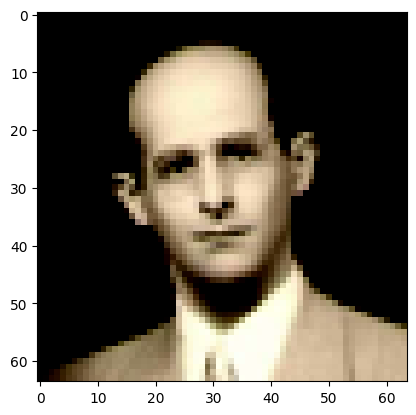

In [ ]:
plt.imshow(x_train[10], cmap = 'gray')

## Define cGAN

In [11]:
cGAN = CGAN_FaceAging()

2023-04-25 15:44:45.730393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10766 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7
/anaconda/envs/ai-seminar-tf/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Train GAN

In [12]:
batch_size = 64

In [13]:
real_labels = np.ones((batch_size, 1), dtype = np.float32) * 0.9
fake_labels = np.zeros((batch_size, 1), dtype = np.float32) * 0.1

In [14]:
cGAN.train(
    epochs=500,
    x_train=x_train,
    y_train=y_train,
    batch_size=batch_size,
    z_shape=100,
    real_labels=real_labels,
    fake_labels=fake_labels
)

2023-04-25 15:44:47.377 | INFO     | src.face_aging:_train_gan:294 - Epoch: 0
2023-04-25 15:44:47.379 | INFO     | src.face_aging:_train_gan:300 - Number of batches: 15
2023-04-25 15:44:47.379 | INFO     | src.face_aging:_train_gan:303 - Batch: 1
2023-04-25 15:44:47.411544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,6]
	 [[{{node Placeholder/_1}}]]
2023-04-25 15:44:48.056165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-25 15:44:49.400529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype fl